### Raspberry Shake data & Python

This notebook will be used to automatically read in MSEED data collected by a Raspberry Shake seismograph and plot events of interest along with the arrival times of various seismic phases.

In [1]:
# Read in the csv file of the earthquakes list

import pandas as pd
import numpy as np

df = pd.read_csv('/home/nicole/seismology/data/eqlist_detections.csv')


In [2]:
# Input the event date, time, and location and set the day of the year variable
# (use the csv file with events downloaded from the USGS)

# --------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------

# Select the row that contains the event
i = 37

# Enter a title for the event
event_title = df.place[i]

# Enter the UTC date and time format: '2017-06-14T00:25:37.310Z'
event = df.time[i]

# Enter the latitude and longitude (southern hemisphere is negative, EASTERN hemisphere is NEGATIVE)
lat = df.latitude[i]
long = -df.longitude[i]

# Enter the depth of the earthquake in km
depth = df.depth[i]*1

# Enter the phases for which to calculate travel times
phases = ['P', 'S']

# --------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------

import numpy as np

# Import the datetime module
from datetime import datetime

# Create a datetime object with the date and time provided above in event
#dt_event = datetime.strptime(event, '%Y-%m-%d %H:%M:%S')
dt_event = datetime.strptime(event, '%Y-%m-%dT%H:%M:%S.%fZ')

# Create a variable for the day of the year using the 'string format time' method
day_yr = dt_event.strftime("%j")

# Set the year, month, and day variables (to be used later)
year = dt_event.year
month = dt_event.month
day = dt_event.day

# Import the module to convert times into a UTC datetime object
from obspy import UTCDateTime

UTCdt_event = UTCDateTime(dt_event)

In [3]:
# Retrieve the MSEED file corresponding to the day number (these files are saved locally)

# Set the path to file location
path = '/home/nicole/seismology/rasp_shake/data/2017/AM/RBF6B/SHZ.D/'

# Set the file name which contains the event
file = 'AM.RBF6B.00.SHZ.D.2017.'+ str(day_yr)

# Import the IO (read) module from the ObsPy package
from obspy import read

# Read in the MSEED file
st_event = read(path+file, format="MSEED")
print(st_event)

# Some files have breaks in them, possibly related to the v4 software update and also relocating and 
# restarting the shake. This results in more than one trace per stream.

# If there is more than one trace, all traces will be merged, filling any missing values with zero 
if len(st_event) > 1:
    st_event = st_event.merge(method=0, fill_value=0)
    print('Traces have been merged.')
    print(st_event)

# Select the only trace in the stream
tr = st_event[0]

117 Trace(s) in Stream:

AM.RBF6B.00.SHZ | 2017-06-10T00:00:05.522000Z - 2017-06-10T10:55:08.042000Z | 50.0 Hz, 1965127 samples
...
(115 other traces)
...
AM.RBF6B.00.SHZ | 2017-06-10T11:41:10.036999Z - 2017-06-10T23:51:15.696999Z | 50.0 Hz, 2190284 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
Traces have been merged.
1 Trace(s) in Stream:
AM.RBF6B.00.SHZ | 2017-06-10T00:00:05.522000Z - 2017-06-10T23:51:15.702000Z | 50.0 Hz, 4293510 samples


In [4]:
# Calculate travel times

from obspy.geodetics import locations2degrees
from obspy.taup import TauPyModel

# Find the distance in degrees to the souce 
# (as recorded at Four Winds Condo [49.738N, 123.0946W])
deg = locations2degrees(lat, long, 49.738, 123.0946)
model = TauPyModel(model="iasp91")

# Use the model to calculate the arrivals

# All arrivals
arrivals = model.get_travel_times(source_depth_in_km=depth, distance_in_degree=deg)

# Arrivals listed above in phases
#arrivals = model.get_travel_times(source_depth_in_km=depth, distance_in_degree=deg, phase_list = phases)

print(arrivals)

# Select the P- and S- arrivals
arrP=arrivals[0].time
arrS=arrivals[19].time

#arrPkikP=arrivals[14].time

# Surface waves - uncomment to calculate and plot
# Rayleigh waves are (maybe) 92% of the velocity of S-waves 
# (multiply arrival time by 1.08)

# arrR=arrS*1.08

47 arrivals
	P phase arrival at 69.208 seconds
	Pn phase arrival at 69.221 seconds
	pP phase arrival at 71.610 seconds
	sP phase arrival at 73.116 seconds
	PP phase arrival at 76.738 seconds
	P phase arrival at 80.322 seconds
	P phase arrival at 80.405 seconds
	pP phase arrival at 81.896 seconds
	pP phase arrival at 81.998 seconds
	PP phase arrival at 83.466 seconds
	sP phase arrival at 83.659 seconds
	sP phase arrival at 83.755 seconds
	PP phase arrival at 84.136 seconds
	P phase arrival at 87.602 seconds
	P phase arrival at 87.660 seconds
	pP phase arrival at 87.973 seconds
	PP phase arrival at 88.356 seconds
	sP phase arrival at 90.079 seconds
	sP phase arrival at 90.235 seconds
	S phase arrival at 123.381 seconds
	Sn phase arrival at 123.422 seconds
	sS phase arrival at 127.337 seconds
	SS phase arrival at 135.674 seconds
	S phase arrival at 139.142 seconds
	S phase arrival at 139.288 seconds
	sS phase arrival at 141.817 seconds
	sS phase arrival at 141.996 seconds
	SS phase arriva

In [5]:
# Filtering with a lowpass on a copy of the original Trace
tr_filt = tr.copy()
tr_filt.filter('lowpass', freq=10.0, corners=4, zerophase=True)

# Make the data vectors of the raw and filtered data
data = tr.data
data_filt = tr_filt.data

In [6]:
# Calculate the event time in seconds
event_s = (dt_event.hour * 3600) + (dt_event.minute * 60) + dt_event.second
print('Event time in seconds:', event_s)

# The Shake starts recording a few seconds after 00:00:00. This offset needs to be accounted for
# in order for the generated time vector to be correct.

offset = tr_filt.stats.starttime
zero = UTCDateTime(year, month, day)
offset_s = offset - zero

Event time in seconds: 74298


In [7]:
# Generate the time vector
obspy_t = tr.times()
print('Time vector (obspy): \n', obspy_t)

# Add the offset to each element of the time vector
obspy_t_off = obspy_t + offset_s
print('Time vector (obspy with offset): \n', obspy_t_off)

Time vector (obspy): 
 [  0.00000000e+00   2.00000000e-02   4.00000000e-02 ...,   8.58701400e+04
   8.58701600e+04   8.58701800e+04]
Time vector (obspy with offset): 
 [  5.52200000e+00   5.54200000e+00   5.56200000e+00 ...,   8.58756620e+04
   8.58756820e+04   8.58757020e+04]


In [8]:
# Convert counts to ground motion (velocity, m/s)

# Remove the DC offset (de-mean)
data_mean = data_filt - np.average(data_filt)

# Convert counts to m/s
# 4.690873E+08 counts = 1 m/s

sens = 4.690873E+08

data_vel = (data_mean / sens) * 1e6

<IPython.core.display.Javascript object>


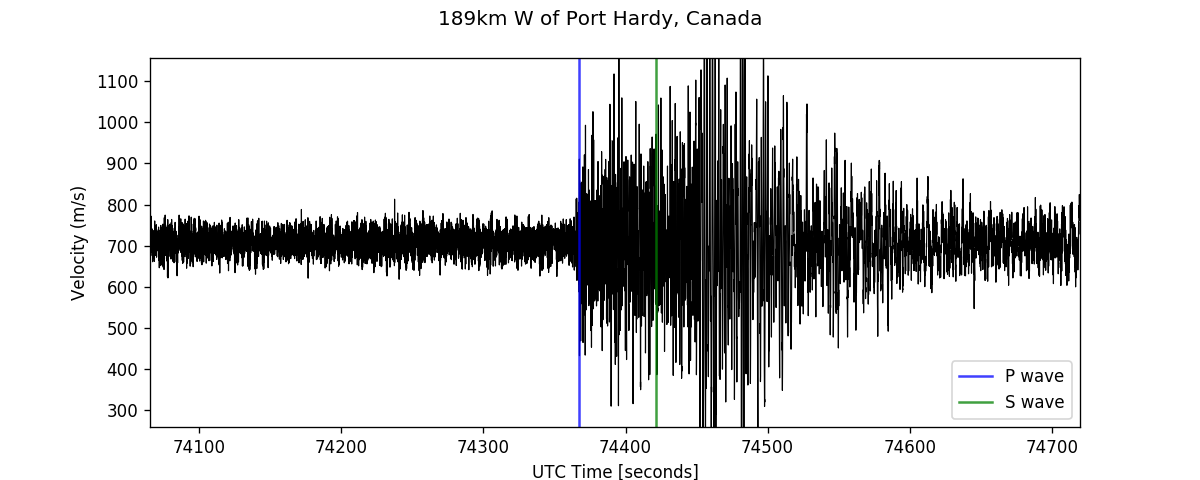

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
from pylab import rcParams

# Set the figure size
rcParams['figure.figsize'] = 10, 4

# Plotting with axes set manually for the desired time window and the x-axis converted to hours
plt.plot(obspy_t_off, data_filt, 'k', linewidth=0.7)

# Unfiltered data - optional to plot
#plt.plot(obspy_t_off, data, 'purple', alpha=0.3)

#plt.axis([event_s+arrP-300, event_s+arrS+600, min(data_filt), max(data_filt)])
plt.axis([event_s+arrP-300, event_s+arrS+300, 100, 1000])

plt.axvline(x=(event_s+arrP), color='blue', label='P wave', alpha=0.75)
plt.axvline(x=(event_s+arrS), color='g',label='S wave', alpha=0.75)

plt.ylabel('Velocity (m/s)')
plt.xlabel('UTC Time [seconds]')
plt.suptitle(event_title)
plt.legend(loc='lower right')

#plt.savefig('/home/nicole/seismology/images/temp_fig.png')